# Load data

In [1]:
%matplotlib inline

import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import sys

In [2]:
result_files = glob.glob("new_results/**/seed*-R10-to-R100-*.csv", recursive=True)

li = []

for filename in result_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    
    f = open(filename + '.meta', "r")
    meta = f.read().split('\n')
    df['seed'] = meta[0][7:]
    df['method'] = meta[1][10:]
    df['lr_schedule'] = meta[4][14:]
    
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

# Aggregate results

In [3]:
def filter_best_results(df):
    idx = df.groupby(['max_iter'], sort=False)['val_loss'].transform(min) == df['val_loss']
    return df[idx]

In [86]:
def aggregate_results(df, schedule):
    hb = filter_best_results(df[(df['method'] == 'Hyperband') & (df['lr_schedule'] == schedule)]).sort_values('max_iter')
    sh = filter_best_results(df[(df['method'] == 'Successive_halving') & (df['lr_schedule'] == schedule)]).sort_values('max_iter')
    return pd.concat([hb, sh])
#pd.options.mode.chained_assignment = None  # default='warn'

#d = df[(df['method'] == 'Successive_halving') & (df['lr_schedule'] == 'Linear') & (df['seed'] == '2020')]
#d['csum'] = d.groupby('max_iter', sort=False)['r_i'].cumsum()
#d.head(50)
def res(df, s, it, m, seed):
    d = df[(df['method'] == 'Successive_halving') & (df['lr_schedule'] == m) & (df['seed'] == seed) & (df['max_iter'] == it)]
    d['csum'] = d['r_i'].cumsum()
    d = d[d['csum' ] <= s+1]
    d = d[d['val_loss'].min() == d['val_loss']]
    d = d.drop(columns='csum')

    c = df[(df['method'] == 'Hyperband') & (df['lr_schedule'] == m) & (df['seed'] == seed) & (df['max_iter'] == it)]
    c = c[c['val_loss'].min() == c['val_loss']]
    return pd.concat([d,c])

,max_iter,learning_rate,bracket,n_i,r_i,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,seed,method,lr_schedule,csum
1162,100,0.018195,4,1.0,100.0,0.56028,79.455288,0.343548,86.683333,0.365758,85.93,2020,Successive_halving,Linear,1000.0
1162,100,0.018195,4,1.0,100.0,0.56028,79.455288,0.343548,86.683333,0.365758,85.93,2020,Successive_halving,Linear,1000.0
1162,100,0.018195,4,1.0,100.0,0.56028,79.455288,0.343548,86.683333,0.365758,85.93,2020,Successive_halving,Linear,1000.0


# Visualize

In [125]:
schedules = ['Linear', 'LambdaLR', 'ExponentialLR', 'CyclicLR', 'StepLR']

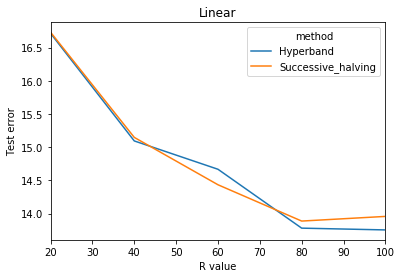

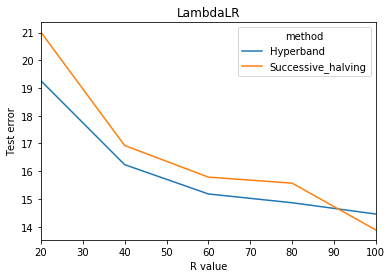

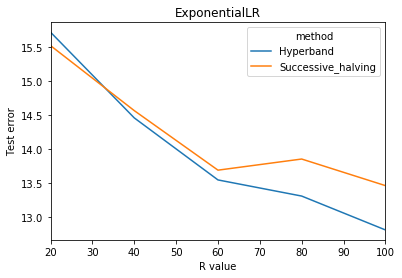

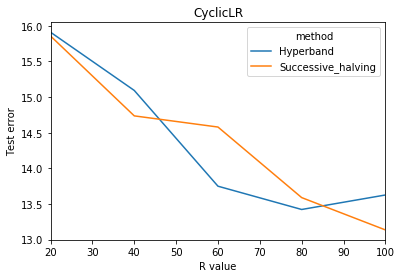

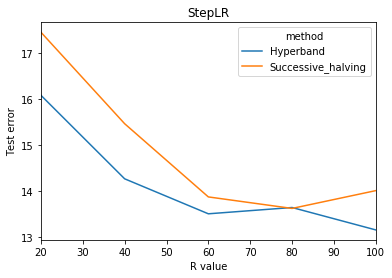

In [129]:
if not os.path.exists('plots'): os.makedirs('plots')

rr = [160, 600, 900, 1200, 2100]
ii = [20, 40, 60, 80, 100]
seed = ['2020', '4040', '6060']
dat = []
mtr = 'test_accuracy'
for schedule in schedules:
    #pivot = aggregate_results(df, schedule).pivot(index='max_iter', columns='method', values='val_loss')
    dd = []
    for i in range(len(rr)):
        for x in seed:
            dd.append(res(df, rr[i], ii[i], schedule,x))
    dd= pd.concat(dd)
    
    dd = dd[['max_iter', 'method', mtr]].groupby(['max_iter', 'method']).mean().reset_index()
    dd[mtr] = 100 - dd[mtr]
    #print(dd.columns)
    #print(dd)
    pivot = dd.pivot(index='max_iter', columns='method', values=mtr)
    ax = pivot.plot(title=schedule)
    ax.set_xlabel("R value")
    ax.set_ylabel("Test error")
    #ax.get_figure().savefig('plots/' + schedule.lower() + '.png')